# Forecasting Delays in the Swiss Transportation System

## Minimal Early EDA: Tests on the Transportation Data `IstData`

Copyrights © 2025, 2026 Yvan Richard.  
All rights reserved.

## Foreword

In this notebook, I rapidly check that the data I prepared from [opentransportdata](https://opentransportdata.swiss/en/) are correctly loaded in my memory and do not present major anomalies.

## 1. Load Data

First, I will load the data for two randomly chosen dates:
* 4th of January 2025
* 21th of September 2025

In [155]:
# load libraries
from pathlib import Path
import pandas as pd
import numpy as np


# load data with parquet
df_1 = pd.read_parquet("../../data/interim/2025_01/2025-01-01_istdaten.parquet")
df_2 = pd.read_parquet("../../data/interim/2025_09/2025-09-21_IstDaten.parquet")

# check dimensions of both dataframes
print("Dataframe 1 shape:", df_1.shape)
print("Dataframe 2 shape:", df_2.shape)


Dataframe 1 shape: (57213, 14)
Dataframe 2 shape: (54792, 14)


The first consistency check was successful. I was able to load both data sets in memory and they roughly have the same observation for one day (i.e. $\approx 55,000$/day), as well as the same number of features.

# 2. Variables Selection

In this section, I briefly inspect the variables in both data sets to make sure that no particular data quality issue emerge
and proceed to select the most relevant variables for my project. The first step is to observe which columns I have:

In [156]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57213 entries, 0 to 57212
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   op_date                57213 non-null  object        
 1   trip_id                57213 non-null  object        
 2   stop_id                57213 non-null  object        
 3   stop_name              57213 non-null  object        
 4   operator_code          57213 non-null  object        
 5   transport_type         57183 non-null  object        
 6   line_id                57213 non-null  object        
 7   line_name              57213 non-null  object        
 8   vehicle_type           57213 non-null  object        
 9   additional_trip        57213 non-null  object        
 10  arrival_scheduled_dt   57213 non-null  datetime64[ns]
 11  arrival_observed_dt    57213 non-null  datetime64[ns]
 12  arrival_delay_minutes  57213 non-null  float64       
 13  i

In [157]:
df_1.tail(10)

,op_date,trip_id,stop_id,stop_name,operator_code,transport_type,line_id,line_name,vehicle_type,additional_trip,arrival_scheduled_dt,arrival_observed_dt,arrival_delay_minutes,is_delayed
57203,01.01.2025,ch:1:sjyid:100001:25698-001,8505404,Cadenazzo,SBB,Zug,25698,S20,S,false,2025-01-02 02:00:00,2025-01-02 01:58:24,-1.600000,0
57204,01.01.2025,ch:1:sjyid:100001:25698-001,8505415,S. Antonino,SBB,Zug,25698,S20,S,false,2025-01-02 02:02:00,2025-01-02 02:02:03,0.050000,0
57205,01.01.2025,ch:1:sjyid:100001:25698-001,8505214,Giubiasco,SBB,Zug,25698,S20,S,false,2025-01-02 02:06:00,2025-01-02 02:05:00,-1.000000,0
57206,01.01.2025,ch:1:sjyid:100001:23096-001,8501007,Vernier,SBB,Zug,23096,RL5,R,false,2025-01-02 02:09:00,2025-01-02 02:08:43,-0.283333,0
57207,01.01.2025,ch:1:sjyid:100001:25698-001,8505213,Bellinzona,SBB,Zug,25698,S20,S,false,2025-01-02 02:11:00,2025-01-02 02:09:09,-1.850000,0
57208,01.01.2025,ch:1:sjyid:100001:23096-001,8501006,Meyrin,SBB,Zug,23096,RL5,R,false,2025-01-02 02:11:00,2025-01-02 02:10:54,-0.100000,0
57209,01.01.2025,ch:1:sjyid:100001:23096-001,8501000,Zimeysa,SBB,Zug,23096,RL5,R,false,2025-01-02 02:13:00,2025-01-02 02:12:26,-0.566667,0
57210,01.01.2025,ch:1:sjyid:100001:23096-001,8501003,Satigny,SBB,Zug,23096,RL5,R,false,2025-01-02 02:16:00,2025-01-02 02:15:42,-0.300000,0
57211,01.01.2025,ch:1:sjyid:100001:23096-001,8501002,Russin,SBB,Zug,23096,RL5,R,false,2025-01-02 02:20:00,2025-01-02 02:20:59,0.983333,0
57212,01.01.2025,ch:1:sjyid:100001:23096-001,8501001,La Plaine,SBB,Zug,23096,RL5,R,false,2025-01-02 02:22:00,2025-01-02 02:24:00,2.000000,0


## 2.1. Variables Description

To understand the data set properly, here is a brief description of the variables based on the [official documentation](https://opentransportdata.swiss/en/cookbook/historic-and-statistics-cookbook/actual-data/).

| Variable Name | Description                                                                |
|:--------------|:---------------------------------------------------------------------------|
| `op_date`     | This is the relevant day of operation when the journey took place.         |
| `trip_id`     | Corresponds to JourneyID. Local services: [UIC country code]:[Business organisation number]:[Journey reference] Rail  services: [UIC country code]:[Business organisation number]:[Form of transport number]:[Extended reference] |
| `stop_id`     | Stop (in BPUIC format). String E.g. from DiDok. Stop’s ID. |
| `stop_name`   | Textual representation of the stop. This is used in the form supplied in the original data from the transport company and is not extracted from BPUIC via BP master data. This means that there can be no discrepancies with the official name in the DiDok list. |
| `line_id` | Line_ID is a purely technical key which is not used for the customer display. [Journey number] (Journey number can be take from FAHRT_BEZEICHNER) |
| `vehicle_type` | Textual description of the form of transport |
| `line_name` | the name of the line (e.g. `IC1`).  Customer-related and is output, if necessary, on the relevant displays. |
| `additional_trip` | binary variable that takes the value true if the trip was added to the timetable (not originally planned). |
| `arrival_scheduled_dt` | During the first pre-processing phase of the data, I only kept observations where we had arrival scheduled and arrival observed available. That way I am able to compute the delay in minutes in `arrival_delay_minute`. |

The other variables are either evident or will not be used because useless after filtering the original raw data.


## 2.2. Reconstructing a Travel

In this section, I demonstrate how to reconstructe a travel with the variable `trip_id`:

In [158]:
len(df_1['trip_id'].unique())

5165

In [159]:
# select a unique trip_id
trip_id = df_1['trip_id'].iloc[0]

# filter dataframe for that trip_id and sort by scheduled_arrival_time
journey_1 = df_1[df_1['trip_id'] == trip_id].sort_values(by=['arrival_scheduled_dt'])

# print the first few stops for that trip_id
journey_1[['stop_name', 'arrival_scheduled_dt', 'arrival_observed_dt']].head(15)

,stop_name,arrival_scheduled_dt,arrival_observed_dt
0,Yvonand,2025-01-01 00:10:00,2025-01-01 00:11:17
2,Cheyres,2025-01-01 00:14:00,2025-01-01 00:14:54
21,Estavayer-le-Lac,2025-01-01 00:19:00,2025-01-01 00:29:57
28,Cugy FR,2025-01-01 00:24:00,2025-01-01 00:34:32
37,Payerne,2025-01-01 00:29:00,2025-01-01 00:38:42
48,Corcelles-Sud,2025-01-01 00:33:00,2025-01-01 00:41:51
93,Grolley,2025-01-01 00:45:00,2025-01-01 00:52:11
121,Belfaux CFF,2025-01-01 00:50:00,2025-01-01 00:56:40
141,Givisiez,2025-01-01 00:53:00,2025-01-01 01:00:24
178,Fribourg/Freiburg,2025-01-01 00:58:00,2025-01-01 01:05:57


And above we see a complete journey from Yvonand (VD) to Fribourg (FR). The travel is depicted here (visualization produced by SBB):

<img src="../../images/travel_ex.png" alt="travel example" width="50%">

## 2.3. Variables Dropping

Now that we have a better idea of the data set in mind, I proceed with identifying some variables that are useless:

In [160]:
# operator_code (should be only SBB)
print(df_1['operator_code'].value_counts())

# transport_type (should be only Zug)
print(df_1['transport_type'].value_counts())

operator_code
SBB    57213
Name: count, dtype: int64
transport_type
Zug    57183
Name: count, dtype: int64


These two variables only take on one possible value, thus they will be unable to explain any variance in the delay times. We can safely drop them in future processing steps.

In [161]:
# additional_trip
# convert to int
df_1['additional_trip'].value_counts()

additional_trip
false    56507
true       706
Name: count, dtype: int64

#### Can `additional_trip` explain variance in these two samples?

I run a very simple check to see if some variance might be explained:

In [162]:
# difference in mean delay (df_1)
# -------------------------------

# convert 'additional_trip' to boolean and then to int
df_1['additional_trip'] = (
    df_1['additional_trip']
    .map({'true': True, 'false': False})
    .astype(int)
)

# calculate mean arrival delay for additional vs non-additional trips
mean_delay_additional = df_1[df_1['additional_trip'] == 1]['arrival_delay_minutes'].mean()
mean_delay_non_additional = df_1[df_1['additional_trip'] == 0]['arrival_delay_minutes'].mean()
print(f"\nMean arrival delay for additional trips: {mean_delay_additional:.2f} minutes")
print(f"Mean arrival delay for non-additional trips: {mean_delay_non_additional:.2f} minutes")


Mean arrival delay for additional trips: 1.43 minutes
Mean arrival delay for non-additional trips: 0.47 minutes


In [163]:
# difference in mean delay (df_2)
# -------------------------------

# convert 'additional_trip' to boolean and then to int
df_2['additional_trip'] = (
    df_2['additional_trip']
    .map({'true': True, 'false': False})
    .astype(int)
)

# calculate mean arrival delay for additional vs non-additional trips
mean_delay_additional_2 = df_2[df_2['additional_trip'] == 1]['arrival_delay_minutes'].mean()
mean_delay_non_additional_2 = df_2[df_2['additional_trip'] == 0]['arrival_delay_minutes'].mean()
print(f"\nMean arrival delay for additional trips (df_2): {mean_delay_additional_2:.2f} minutes")
print(f"Mean arrival delay for non-additional trips (df_2): {mean_delay_non_additional_2:.2f} minutes")


Mean arrival delay for additional trips (df_2): 0.75 minutes
Mean arrival delay for non-additional trips (df_2): 0.71 minutes


At this stage, it is not necessary clear (we would need more observations for that) if `additional_trip` is a useful variable for predicting delays. Hence, I do not discard this value at this stage.

#### `line_id`

In [164]:
# number of unique line_id values in each dataframe
unique_line_ids_df1 = df_1['line_id'].nunique()
unique_line_ids_df2 = df_2['line_id'].nunique()
print(f"\nNumber of unique line_id values in df_1: {unique_line_ids_df1}")
print(f"Number of unique line_id values in df_2: {unique_line_ids_df2}")

# number of unique trip_id values in each dataframe
unique_trip_ids_df1 = df_1['trip_id'].nunique()
unique_trip_ids_df2 = df_2['trip_id'].nunique()
print(f"\nNumber of unique trip_id values in df_1: {unique_trip_ids_df1}")
print(f"Number of unique trip_id values in df_2: {unique_trip_ids_df2}")


Number of unique line_id values in df_1: 5165
Number of unique line_id values in df_2: 5518

Number of unique trip_id values in df_1: 5165
Number of unique trip_id values in df_2: 5518


I now check if `line_id` encodes the same info as `trip_id`:

In [165]:
# check if line_id and trip_id combinations are unique
line_trip_combinations_df1 = df_1[['line_id', 'trip_id']].drop_duplicates()
line_trip_combinations_df2 = df_2[['line_id', 'trip_id']].drop_duplicates()
print(f"\nNumber of unique line_id and trip_id combinations in df_1: {len(line_trip_combinations_df1)}")
print(f"Number of unique line_id and trip_id combinations in df_2: {len(line_trip_combinations_df2)}")


Number of unique line_id and trip_id combinations in df_1: 5165
Number of unique line_id and trip_id combinations in df_2: 5518


In both datasets, `line_id` and `trip_id` are in a one-to-one relationship and therefore encode identical information. Retaining both variables is redundant. I will keep only `trip_id`.

#### `arrival_delay_minutes`

Before concluding my minimal EDA, I quickly compute summary statistics of this variable to check that nothing weird appear.

In [166]:
# summary statistics for arrival_delay_minutes in both dataframes
print("\nSummary statistics for arrival_delay_minutes in df_1:")
print(df_1['arrival_delay_minutes'].describe())
print("\nSummary statistics for arrival_delay_minutes in df_2:")
print(df_2['arrival_delay_minutes'].describe())


Summary statistics for arrival_delay_minutes in df_1:
count    57213.000000
mean         0.480918
std          1.572476
min        -24.300000
25%         -0.200000
50%          0.300000
75%          0.850000
max         60.666667
Name: arrival_delay_minutes, dtype: float64

Summary statistics for arrival_delay_minutes in df_2:
count    54792.000000
mean         0.707952
std          2.289829
min         -9.983333
25%         -0.100000
50%          0.416667
75%          1.066667
max        169.583333
Name: arrival_delay_minutes, dtype: float64


A negative delay is not a mistake, it just means that the train was in advance...

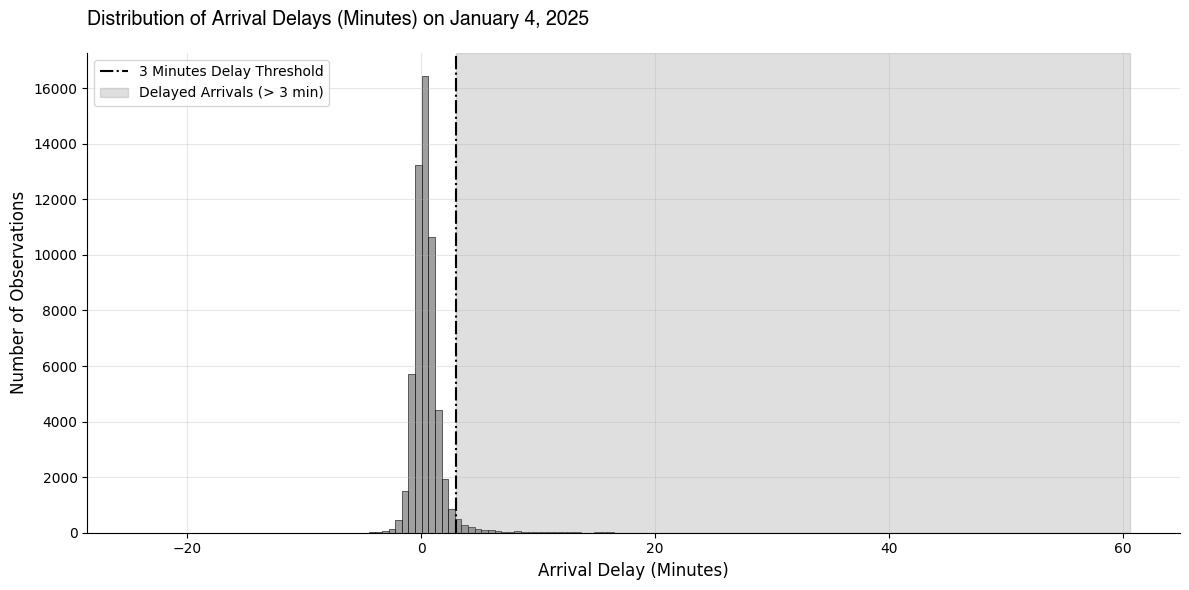

In [167]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(data=df_1, x='arrival_delay_minutes', bins=150, kde=False, ax=ax, color='grey', edgecolor='black')
ax.axvline(3, color='black', linestyle='-.', label='3 Minutes Delay Threshold')
ax.axvspan(3, df_1['arrival_delay_minutes'].max(), color='grey', alpha=0.25, label='Delayed Arrivals (> 3 min)')

# aesthetic adjustments
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Distribution of Arrival Delays (Minutes) on January 4, 2025',
             fontsize=14, family="Helvetica", loc ='left', pad =20)
ax.grid(alpha=0.3)
ax.set_xlabel('Arrival Delay (Minutes)', fontsize=12)
ax.set_ylabel('Number of Observations', fontsize=12)
ax.legend()
plt.tight_layout()
plt.show()

## 2.4. Conclusion

As for now, I will drop:

* `line_id` (I keep `line_name` for now because it is visual for end users)
* `operator_code`
* `transport_type`

In [168]:
# df for the whole month of January 2025
df_january = pd.read_parquet("../../data/interim/ist_clean_2025_01.parquet")
df_january.shape

(1796287, 14)

In [169]:
localities = df_january['stop_name'].unique()

for loc in localities[:10]:
    print(loc)

Yvonand
Freienbach SBB
Cheyres
Bäch SZ
Steinhausen Rigiblick
Richterswil
Steinhausen
Jona
Stabio
Balerna


In [170]:
df_linie = pd.read_parquet("../../data/interim/linie_geo_clean.parquet")
df_linie.head(10)

,stop_id,stop_name,latitude,longitude
0,8502113,Aarau,47.391360,8.051274
1,8504404,Aarberg,47.044541,7.278693
2,8508141,Aarburg-Oftringen,47.313647,7.906872
3,8500117,Aesch BL,47.467745,7.603068
4,8501435,Monthey Agip (embr),46.288697,6.935940
5,8506199,Altishausen,47.596488,9.162377
6,8501400,Aigle,46.316855,6.963683
7,8506125,Altnau,47.621368,9.265918
8,8506047,Andelfingen,47.593766,8.678002
9,8500223,Arch,47.164467,7.418489


In [171]:
print(df_linie['stop_id'].duplicated().sum())

525
